In [1]:
from platform import python_version
print(python_version())

3.7.10


A: The usage of the data set is unrestricted. But you should provide the link to our original download site, acknowledge the NIH Clinical Center and provide a citation to our CVPR 2017 paper

A: ‘No finding’ means the 14 listed disease patterns are not found in the image. 

https://www.kaggle.com/nih-chest-xrays/data

Citations
Wang X, Peng Y, Lu L, Lu Z, Bagheri M, Summers RM. ChestX-ray8: Hospital-scale Chest X-ray Database and Benchmarks on Weakly-Supervised Classification and Localization of Common Thorax Diseases. IEEE CVPR 2017, ChestX-ray8_Hospital-Scale_Chest_CVPR_2017_paper.pdf

NIH News release: NIH Clinical Center provides one of the largest publicly available chest x-ray datasets to scientific community

Original source files and documents: https://nihcc.app.box.com/v/ChestXray-NIHCC/folder/36938765345

### Context Behind Dataset for Final Writeup:

Dataset was gathered by the NIH and contains over 100,000 anonymized chest x-ray images from more than 30,000 patients.  

# Goal
The goal is to use a simple model to classify x-ray images in Keras

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt


Bad key "text.kerning_factor" on line 4 in
/home/ubuntu/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [3]:
import tensorflow

In [4]:
all_xray_df = pd.read_csv('../data/Data_Entry_2017.csv')
folderlist = glob(os.path.join('../data', 'images*'))
imglist = []
for folder in folderlist:
    tmp = glob(os.path.join(folder, "images", "*.png"))
    imglist += tmp
all_image_paths = {os.path.basename(x): x for x in imglist}
#{k:all_image_paths[k] for k in all_image_paths.keys()[:5]}
list(all_image_paths.items())[:4]
# all_image_paths = {os.path.basename(x): x for x in 
#                    glob(os.path.join('.', 'data', 'images*', '*.png'))}



[('00018942_001.png', '../data/images_009/images/00018942_001.png'),
 ('00020323_001.png', '../data/images_009/images/00020323_001.png'),
 ('00018730_001.png', '../data/images_009/images/00018730_001.png'),
 ('00019551_000.png', '../data/images_009/images/00019551_000.png')]

In [5]:
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
num_selected = 10000
tmp = {key: all_image_paths[key] for key in sorted(list(all_image_paths.keys()))[num_selected:]}
print(list(tmp.items())[:4])
all_xray_df['path'] = all_xray_df['Image Index'][num_selected:].map(tmp.get)
all_xray_df = all_xray_df[num_selected:]
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120
[('00002587_005.png', '../data/images_002/images/00002587_005.png'), ('00002588_000.png', '../data/images_002/images/00002588_000.png'), ('00002589_000.png', '../data/images_002/images/00002589_000.png'), ('00002589_001.png', '../data/images_002/images/00002589_001.png')]


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
104552,00027969_003.png,No Finding,3,27969,56,M,PA,2021,2021,0.194311,0.194311,NaN,../data/images_011/images/00027969_003.png
39970,00010447_000.png,Mass,0,10447,62,F,AP,2500,2048,0.168000,0.168000,NaN,../data/images_005/images/00010447_000.png
74088,00018218_000.png,Atelectasis,0,18218,63,M,PA,2992,2991,0.143000,0.143000,NaN,../data/images_008/images/00018218_000.png


In [6]:
label_counts = all_xray_df['Finding Labels'].value_counts()
label_counts

No Finding                                                                          54652
Infiltration                                                                         8734
Atelectasis                                                                          3848
Effusion                                                                             3659
Nodule                                                                               2495
Mass                                                                                 2015
Pneumothorax                                                                         1972
Effusion|Infiltration                                                                1511
Atelectasis|Infiltration                                                             1237
Consolidation                                                                        1199
Atelectasis|Effusion                                                                 1091
Pleural_Th

# Preprocessing Labels
Here we take the labels and make them into a more clear format. The primary step is to see the distribution of findings and then to convert them to simple binary labels

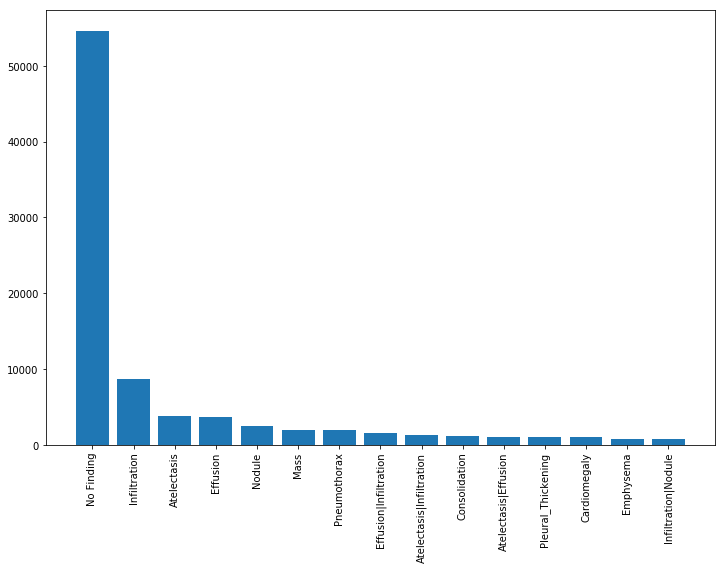

In [7]:
label_counts = all_xray_df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

In [8]:
n_priorities = 4
priority1=['Pneumothorax']
priority2=['Pneumonia','Edema']
priority3=['Atelectasis','Cardiomegaly','Consolidation','Effusion','Emphysema','Fibrosis','Infiltration','Mass','Nodule','Pleural_Thickening']
priority4=['No Finding']

In [9]:
def priority_val(x):
    if any(item in priority1 for item in x):
        return 'priority1'
    elif any(item in priority2 for item in x):
        return 'priority2'
    elif any(item in priority3 for item in x):
        return 'priority3'
    elif any(item in priority4 for item in x):
        return 'priority4'
    
    

In [10]:
from itertools import chain
all_xray_df['Priority Label']=all_xray_df['Finding Labels'].map(lambda x: priority_val(x.split('|')))
all_xray_df['Priority Label'].sample(3)

12561    priority3
70088    priority4
11705    priority4
Name: Priority Label, dtype: object

In [11]:
#all_xray_df['Finding Labels'] = all_xray_df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
from itertools import chain
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
23641,00006260_002.png,No Finding,2,6260,63,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
71429,00017606_032.png,No Finding,32,17606,56,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
91780,00022883_009.png,No Finding,9,22883,67,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [12]:
all_labels

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'No Finding',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

### Clean categories
Since we have too many categories, we can prune a few out by taking the ones with only a few examples

In [13]:
# keep at least 1000 cases
MIN_CASES = 1000
all_labels = [c_label for c_label in all_labels if all_xray_df[c_label].sum()>MIN_CASES]
print('Clean Labels ({})'.format(len(all_labels)), 
      [(c_label,int(all_xray_df[c_label].sum())) for c_label in all_labels])

Clean Labels (14) [('Atelectasis', 10670), ('Cardiomegaly', 2476), ('Consolidation', 4271), ('Edema', 2150), ('Effusion', 12410), ('Emphysema', 2295), ('Fibrosis', 1407), ('Infiltration', 18291), ('Mass', 5454), ('No Finding', 54652), ('Nodule', 5887), ('Pleural_Thickening', 3060), ('Pneumonia', 1296), ('Pneumothorax', 4862)]


In [14]:

res = [i for i, val in enumerate(list(all_xray_df['Priority Label'])) if val == None]


In [15]:
all_xray_df['Priority Label']
res = [i for i, val in enumerate(list(all_xray_df['Priority Label'])) if val == None]
print(res)

[1589, 1590, 1591, 1592, 2428, 2525, 5023, 5024, 5579, 6034, 9541, 9590, 11551, 12815, 13240, 14244, 14781, 15532, 15536, 16160, 18209, 19618, 20263, 20280, 20754, 22253, 22528, 23133, 23135, 23137, 24265, 27971, 28351, 36105, 36669, 37468, 39653, 40594, 40972, 42639, 43035, 43038, 43043, 43048, 44689, 44822, 44823, 44824, 46170, 46797, 48269, 59434, 59781, 62160, 63688, 64700, 67454, 67543, 67544, 70765, 73006, 74376, 74874, 74875, 74876, 74877, 76994, 77002, 77003, 78462, 78588, 78821, 81356, 84724, 84734, 84878, 87051, 90738, 90847, 92747, 93654, 95367, 97271, 97273, 97276, 97927, 98497, 99616]


In [16]:
res = [i for i, val in enumerate(list(all_xray_df['Priority Label'])) if val == None]
res
rows=all_xray_df.index[res]
all_xray_df=all_xray_df.drop(rows)

In [17]:
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
18406,00004893_060.png,No Finding,60,4893,32,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
92035,00022971_004.png,Infiltration,4,22971,62,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
91930,00022931_000.png,Cardiomegaly,0,22931,25,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
np.unique(list(all_xray_df['Priority Label']))

array(['priority1', 'priority2', 'priority3', 'priority4'], dtype='<U9')

In [19]:
all_priorities = np.unique(all_xray_df['Priority Label'])
#all_priorities = [x for x in all_priorities if len(x)>0]
all_priorities

array(['priority1', 'priority2', 'priority3', 'priority4'], dtype=object)

In [20]:
print('All Priorities ({}): {}'.format(len(all_priorities), all_priorities))
for p_label in all_priorities:
    if len(p_label)>1: # leave out empty labels
        all_xray_df[p_label] = all_xray_df['Priority Label'].map(lambda finding: 1.0 if p_label in finding else 0)
all_xray_df.sample(3)

All Priorities (4): ['priority1' 'priority2' 'priority3' 'priority4']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,priority1,priority2,priority3,priority4
40894,00010594_000.png,No Finding,0,10594,22,F,PA,2992,2991,0.143,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
77633,00019087_019.png,Infiltration,19,19087,33,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
61434,00015163_000.png,Mass,0,15163,76,M,PA,2992,2991,0.143,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [21]:
for c_label, s_count in zip(all_labels, np.mean(all_xray_df[all_labels].values,0)):
    print('%s: %f' % (c_label, s_count))
arrivals=np.array(np.mean(all_xray_df[all_labels].values,0))
arrivals=arrivals/arrivals.sum(axis=0,keepdims=True)
disease_priority=np.array([[0,0,1,0],[0,0,1,0],[0,0,1,0],[0,1,0,0],[0,0,1,0],
                  [0,0,1,0],[0,0,1,0],[0,0,1,0],[0,0,1,0],[0,0,0,1],
                  [0,0,1,0],[0,0,1,0],[0,1,0,0],[1,0,0,0]])
print(arrivals)
priority_arrivals=np.array(np.mean(all_xray_df[all_priorities].values,0))
print(priority_arrivals)

Atelectasis: 0.104575
Cardiomegaly: 0.024267
Consolidation: 0.041859
Edema: 0.021072
Effusion: 0.121629
Emphysema: 0.022493
Fibrosis: 0.013790
Infiltration: 0.179267
Mass: 0.053454
No Finding: 0.535636
Nodule: 0.057698
Pleural_Thickening: 0.029991
Pneumonia: 0.012702
Pneumothorax: 0.047652
[0.08259729 0.01916691 0.03306214 0.01664331 0.09606676 0.01776577
 0.01089169 0.14159203 0.04221983 0.42306531 0.04557172 0.02368769
 0.01003244 0.03763711]
[0.04765172 0.0300886  0.3866238  0.53563588]


In [22]:
print(all_xray_df[all_labels].sum())
print(all_xray_df[all_priorities].sum())

Atelectasis           10670.0
Cardiomegaly           2476.0
Consolidation          4271.0
Edema                  2150.0
Effusion              12410.0
Emphysema              2295.0
Fibrosis               1407.0
Infiltration          18291.0
Mass                   5454.0
No Finding            54652.0
Nodule                 5887.0
Pleural_Thickening     3060.0
Pneumonia              1296.0
Pneumothorax           4862.0
dtype: float64
priority1     4862.0
priority2     3070.0
priority3    39448.0
priority4    54652.0
dtype: float64


In [23]:
all_xray_df1 = all_xray_df[all_xray_df['Priority Label'] == "priority1"].sample(frac=5,replace=True)


In [24]:
all_xray_df2 = all_xray_df[all_xray_df['Priority Label'] == "priority2"].sample(frac=10,replace=True)

In [25]:
all_xray_df3 = all_xray_df[all_xray_df['Priority Label'] == "priority3"].sample(frac=5,replace=True)

In [26]:
all_xray_df_bal = pd.concat([all_xray_df,all_xray_df1,all_xray_df2,all_xray_df3],ignore_index=True)

In [27]:
all_xray_df_bal=all_xray_df_bal.sample(frac=0.5)

In [28]:
print(all_xray_df_bal[all_priorities].sum())

priority1     14356.0
priority2     16798.0
priority3    118595.0
priority4     27392.0
dtype: float64


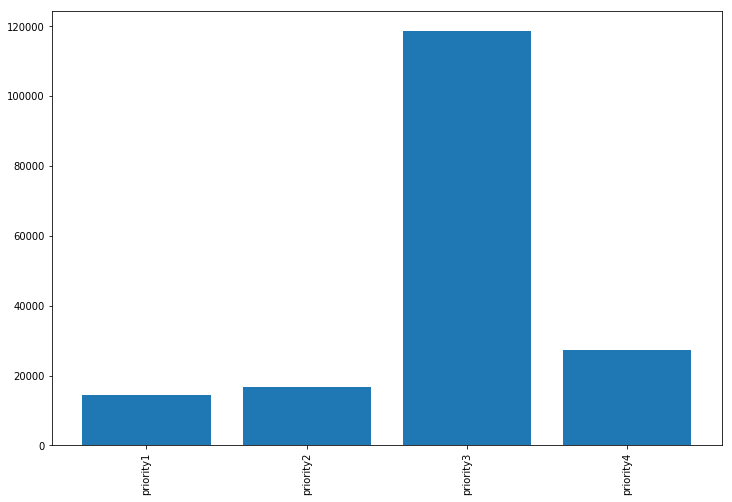

In [29]:
label_counts = all_xray_df_bal[all_priorities].sum()
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

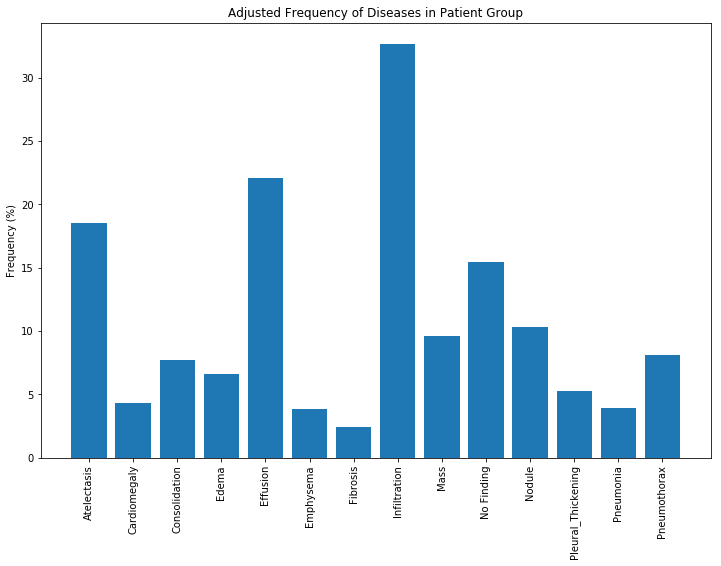

In [30]:
label_counts = 100*np.mean(all_xray_df_bal[all_labels].values,0)
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
ax1.set_xticklabels(all_labels, rotation = 90)
ax1.set_title('Adjusted Frequency of Diseases in Patient Group')
_ = ax1.set_ylabel('Frequency (%)')

# Prepare Training Data
Here we split the data into training and validation sets and create a single vector (disease_vec) with the 0/1 outputs for the disease status (what the model will try and predict)

In [31]:
all_xray_df['disease_vec'] = all_xray_df.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])
all_xray_df['priority_vec'] = all_xray_df.apply(lambda x: [x[all_priorities].values], 1).map(lambda x: x[0])

In [32]:
print(all_xray_df['disease_vec'].sample(3))
print(all_xray_df['priority_vec'].sample(3))

75480     [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, ...
111005    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
79484     [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...
Name: disease_vec, dtype: object
55051    [0.0, 0.0, 1.0, 0.0]
17807    [1.0, 0.0, 0.0, 0.0]
74904    [0.0, 0.0, 0.0, 1.0]
Name: priority_vec, dtype: object


In [33]:
all_xray_df_bal['disease_vec'] = all_xray_df_bal.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])
all_xray_df_bal['priority_vec'] = all_xray_df_bal.apply(lambda x: [x[all_priorities].values], 1).map(lambda x: x[0])

In [34]:
print(all_xray_df_bal['disease_vec'].sample(3))
print(all_xray_df_bal['priority_vec'].sample(3))

343692    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...
148369    [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...
296081    [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, ...
Name: disease_vec, dtype: object
323749    [0.0, 0.0, 1.0, 0.0]
307353    [0.0, 0.0, 1.0, 0.0]
17142     [0.0, 0.0, 1.0, 0.0]
Name: priority_vec, dtype: object


In [35]:
df=all_xray_df.sample(40000)
from sklearn.model_selection import train_test_split
valid_df, test_df = train_test_split(df, 
                                   test_size = 0.5, 
                                   random_state = 2018,
                                   stratify = df['Priority Label'])

/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1462: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return floored.astype(np.int)
/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1462: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to revie

In [36]:
train_df = all_xray_df_bal

In [37]:
print('train', train_df.shape, 'validation', valid_df.shape,'test', test_df.shape)

train (177141, 35) validation (20000, 35) test (20000, 35)


In [38]:
train_df['newLabel'] = train_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)
train_df['newLabelP'] = train_df['Priority Label']
print(train_df.sample(3))

             Image Index Finding Labels  Follow-up #  Patient ID  Patient Age  \
11748   00005773_013.png       Effusion           13        5773           37   
346179  00025169_001.png   Infiltration            1       25169           60   
127133  00011632_018.png          Edema           18       11632           57   

       Patient Gender View Position  OriginalImage[Width  Height]  \
11748               F            AP                 2500     2048   
346179              F            PA                 2992     2991   
127133              M            AP                 2500     2048   

        OriginalImagePixelSpacing[x  ...  Pneumonia  Pneumothorax priority1  \
11748                         0.168  ...        0.0           0.0       0.0   
346179                        0.143  ...        0.0           0.0       0.0   
127133                        0.168  ...        0.0           0.0       0.0   

       priority2  priority3  priority4  \
11748        0.0        1.0        0.0 

In [39]:
valid_df['newLabel'] = valid_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)
valid_df['newLabelP'] = valid_df['Priority Label']
print(valid_df.sample(3))

             Image Index Finding Labels  Follow-up #  Patient ID  Patient Age  \
39209   00010289_000.png     No Finding            0       10289           48   
25515   00006712_000.png           Mass            0        6712           44   
106085  00028549_005.png   Cardiomegaly            5       28549           33   

       Patient Gender View Position  OriginalImage[Width  Height]  \
39209               M            PA                 2992     2991   
25515               M            PA                 2500     2048   
106085              F            AP                 3056     2544   

        OriginalImagePixelSpacing[x  ...  Pneumonia  Pneumothorax priority1  \
39209                         0.143  ...        0.0           0.0       0.0   
25515                         0.171  ...        0.0           0.0       0.0   
106085                        0.139  ...        0.0           0.0       0.0   

       priority2  priority3  priority4  \
39209        0.0        0.0        1.0 

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [40]:
test_df['newLabel'] = test_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)
test_df['newLabelP'] = test_df['Priority Label']
print(test_df.sample(3))

             Image Index             Finding Labels  Follow-up #  Patient ID  \
105975  00028523_006.png  Atelectasis|Consolidation            6       28523   
83768   00020580_000.png                 No Finding            0       20580   
85482   00021072_003.png                 No Finding            3       21072   

        Patient Age Patient Gender View Position  OriginalImage[Width  \
105975           58              M            AP                 3056   
83768            55              F            PA                 2388   
85482            62              M            AP                 3056   

        Height]  OriginalImagePixelSpacing[x  ...  Pneumonia  Pneumothorax  \
105975     2544                        0.139  ...        0.0           0.0   
83768      2961                        0.139  ...        0.0           0.0   
85482      2544                        0.139  ...        0.0           0.0   

       priority1 priority2  priority3  priority4  \
105975       0.0     

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [41]:
import tensorflow as tf
def queue_wait_cost(pmat,costs,arrivals,service):
    clambda = costs*arrivals
    rho = arrivals/service
    clambda_pmat = np.matmul(clambda,pmat)
    rho_pmat = np.matmul(rho,pmat)
    vec1=1-np.cumsum(rho_pmat)
    vec2=np.roll(1-np.cumsum(rho_pmat),1)
    vec2[0]=1
    denom = (1/vec1)*(1/vec2)
    return sum(clambda_pmat*denom)
def queue_wait_cost_priority(pmat,priority_costs,priority_arrivals,priority_service):
    clambda = priority_costs*priority_arrivals
    rho = priority_arrivals/priority_service
    clambda_pmat = np.matmul(clambda,pmat)
    rho_pmat = np.matmul(rho,pmat)
    vec1=1-np.cumsum(rho_pmat)
    vec2=np.roll(1-np.cumsum(rho_pmat),1)
    vec2[0]=1
    denom = (1/vec1)*(1/vec2)
    return sum(clambda_pmat*denom)
def queue_loss(y_true,y_pred):
    y_pred = y_pred/y_pred.sum(axis=1,keepdims=True)
    pmat = np.matmul(np.transpose(y_true),y_pred)
    pmat = pmat/pmat.sum(axis=1,keepdims=True)
    clambda = costs*arrivals
    rho = arrivals/service
    clambda_pmat = np.matmul(clambda,pmat)
    rho_pmat = np.matmul(rho,pmat)
    vec1=1-np.cumsum(rho_pmat)
    vec2=np.roll(1-np.cumsum(rho_pmat),1)
    vec2[0]=1
    denom = (1/vec1)*(1/vec2)
    return sum(clambda_pmat*denom)

def queue_loss_tensor(y_true,y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    #y_pred = tf.divide(y_pred,tf.reduce_sum(y_pred,axis=1,keepdims=True)+0.000000000001)
    pmat = tf.matmul(tf.transpose(y_true),y_pred)
    pmat = tf.divide(pmat,tf.reduce_sum(pmat,axis=1,keepdims=True)+0.000000000001)
    clambda = tf.reshape(tf.cast(tf.Variable(costs*arrivals),tf.float32),[1,14])
    rho = tf.reshape(tf.cast(tf.Variable(arrivals/service),tf.float32),[1,14])
    #print(rho.shape)
    clambda_pmat = tf.matmul(clambda,pmat)
    rho_pmat = tf.matmul(rho,pmat)
    vec1=1-tf.cumsum(rho_pmat,axis=1)
    #print(vec1)
    vec2=tf.roll(1-tf.cumsum(rho_pmat,axis=1),shift=1,axis=1)
    #print(vec2)
    vec2=tf.tensor_scatter_nd_update(vec2,indices=[[0,0]],updates=[1])
    #print(vec2)
    #print (tf.math.reciprocal(vec2))
    denom = tf.multiply(tf.math.reciprocal(vec1+0.00000000000001),tf.math.reciprocal(vec2+0.00000000000001))
    return tf.reshape(tf.reduce_sum(tf.multiply(clambda_pmat,denom)),[])
def queue_loss_tensor_priority(y_true,y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    #y_pred = tf.divide(y_pred,tf.reduce_sum(y_pred,axis=1,keepdims=True)+0.000000000001)
    pmat = tf.matmul(tf.transpose(y_true),y_pred)
    pmat = tf.divide(pmat,tf.reduce_sum(pmat,axis=1,keepdims=True)+0.000000000001)
    clambda = tf.reshape(tf.cast(tf.Variable(priority_costs*priority_arrivals),tf.float32),[1,n_priorities])
    rho = tf.reshape(tf.cast(tf.Variable(priority_arrivals/priority_service),tf.float32),[1,n_priorities])
    #print(rho.shape)
    clambda_pmat = tf.matmul(clambda,pmat)
    rho_pmat = tf.matmul(rho,pmat)
    vec1=1-tf.cumsum(rho_pmat,axis=1)
    #print(vec1)
    vec2=tf.roll(1-tf.cumsum(rho_pmat,axis=1),shift=1,axis=1)
    #print(vec2)
    vec2=tf.tensor_scatter_nd_update(vec2,indices=[[0,0]],updates=[1])
    #print(vec2)
    #print (tf.math.reciprocal(vec2))
    denom = tf.multiply(tf.math.reciprocal(vec1+0.00000000000001),tf.math.reciprocal(vec2+0.00000000000001))
    return tf.reshape(tf.reduce_sum(tf.multiply(clambda_pmat,denom)),[])
    

# Training the Model

In [42]:
n_priorities=4

In [43]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from keras import optimizers, callbacks, regularizers

Using TensorFlow backend.


In [44]:
def MakeModel1(IMG_SIZE, bs, channels=1):
    model = Sequential()
    base_mobilenet_model = MobileNet(input_shape =  (*IMG_SIZE, channels), #Need to define the shape here from IMG_SIZE
                                 include_top = False, weights = None)
    model.add(base_mobilenet_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(512))
    model.add(Dropout(0.5))
    model.add(Dense(len(all_labels), activation = 'sigmoid'))
    return model
def MakeModel2(n_priorities,IMG_SIZE, bs, channels=1):
    model = Sequential()
    base_mobilenet_model = MobileNet(input_shape =  (*IMG_SIZE, channels), #Need to define the shape here from IMG_SIZE
                                 include_top = False, weights = None)
    model.add(base_mobilenet_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(512))
    model.add(Dropout(0.5))
    model.add(Dense(len(all_labels),activation = 'sigmoid'))
    model.add(Dense(n_priorities, activation = 'softmax'))
    return model
def MakeModel3(n_priorities,IMG_SIZE, bs, channels=1):
    model = Sequential()
    base_mobilenet_model = MobileNet(input_shape =  (*IMG_SIZE, channels), #Need to define the shape here from IMG_SIZE
                                 include_top = False, weights = None)
    model.add(base_mobilenet_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(512))
    model.add(Dropout(0.5))
    model.add(Dense(n_priorities, activation = 'softmax'))
    return model

In [45]:
from keras.preprocessing.image import ImageDataGenerator
core_idg = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.1, 
                              rotation_range=5, 
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.15)

In [46]:
n_priorities=4

In [47]:
lr = 0.0005
syntheticBatch = 256
imageSize = (512, 512)
colorMode = 'rgb'
channels = 3
batchSize = 32
batch = int(256 / batchSize)
STEPS_PER_EPOCH = 1000
EPOCHS = 100
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.direct.june9.hdf5".format('xray_class')
checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=5)
callbacks_list = [checkpoint, early]


train_gen = core_idg.flow_from_dataframe(dataframe=train_df, 
                         directory=None,
                         x_col = 'path',
                        y_col = 'newLabelP', 
                         class_mode = 'categorical',
                        target_size = imageSize,
                         color_mode = colorMode,
                        batch_size = batchSize)

valid_gen = core_idg.flow_from_dataframe(dataframe=valid_df, 
                         directory=None,
                         x_col = 'path',
                        y_col = 'newLabelP', 
                        class_mode = 'categorical',
                        target_size = imageSize,
                         color_mode = colorMode,
                        batch_size = batchSize) # we can use much larger batches for evaluation


opt = tensorflow.keras.optimizers.Adam(
    learning_rate=lr,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam"
)


Found 177141 validated image filenames belonging to 4 classes.
Found 20000 validated image filenames belonging to 4 classes.


In [48]:
import gc
gc.collect()

108

In [49]:
import gc
gc.collect()
multi_disease_model = MakeModel3(n_priorities,imageSize, batchSize, channels)
#multi_disease_model.load_weights("xray_class_weights.best.direct.june9.hdf5")


In [ ]:
multi_disease_model = MakeModel3(n_priorities,imageSize, batchSize, channels)
multi_disease_model.load_weights('xray_class_weights.best.queue_r_10.june1.hdf5')

In [ ]:
multi_disease_model.compile(optimizer = opt, loss = 'categorical_crossentropy',
       run_eagerly=True,metrics = ['accuracy'])

In [ ]:
history = multi_disease_model.fit_generator(train_gen,                           
              validation_data = valid_gen, 
              steps_per_epoch=1000,                              
              epochs = 20, 
              callbacks = callbacks_list)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
 149/1000 [===>..........................] - ETA: 38:06 - loss: 0.9053 - accuracy: 0.6476

In [ ]:
history.history

In [68]:
test_X, test_Y = next(core_idg.flow_from_dataframe(dataframe=valid_df, 
                         directory=None,
                         x_col = 'path',
                        y_col = 'newLabelP', 
                         class_mode = 'categorical',
                        target_size = imageSize,
                         color_mode = 'rgb',
                        batch_size = 2000))

Found 20000 validated image filenames belonging to 4 classes.


In [69]:
pred_Y = multi_disease_model.predict(test_X, batch_size = 32, verbose = True)

63/63 [==============================] - 19s 303ms/step


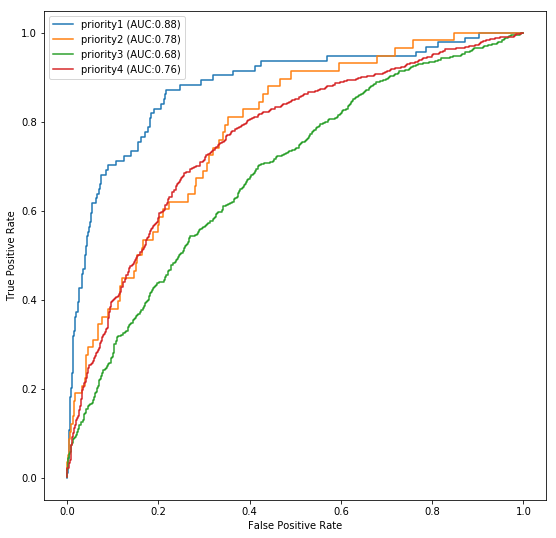

In [70]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(all_priorities):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('trained_net.pdf')

In [71]:
pred_Y

array([[0.07579165, 0.22063324, 0.5730394 , 0.13053568],
       [0.06843232, 0.18068889, 0.654654  , 0.09622476],
       [0.22334816, 0.05271852, 0.57024556, 0.15368776],
       ...,
       [0.03466288, 0.09116952, 0.63026255, 0.24390508],
       [0.7630999 , 0.00819605, 0.17793757, 0.05076637],
       [0.04219628, 0.19220462, 0.5975918 , 0.16800733]], dtype=float32)

In [72]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_priorities):
    fpr[i], tpr[i], _ = roc_curve(test_Y[:, i], pred_Y[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(test_Y.ravel(), pred_Y.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [73]:
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_priorities)]))

In [74]:
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  """


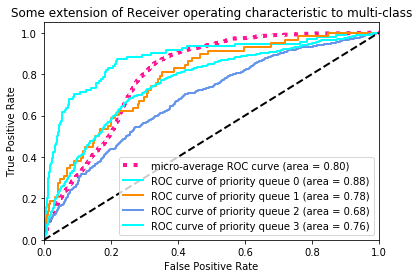

In [81]:
# Then interpolate all ROC curves at this points
lw=2
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_priorities):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_priorities

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
#plt.plot(fpr["micro"], tpr["micro"],
 #        label='micro-average ROC curve (area = {0:0.2f})'
 #              ''.format(roc_auc["micro"]),
 #        color='deeppink', linestyle=':', linewidth=4)

#plt.plot(fpr["macro"], tpr["macro"],
        # label='macro-average ROC curve (area = {0:0.2f})'
        #       ''.format(roc_auc["macro"]),
        # color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(0,n_priorities,1), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of priority queue {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()